# Comparing an insurer’s perspective on building damages with modelled damages from pan-European windstorm event sets: a use-case from Zurich, Switzerland

Christoph Welker1, Thomas Röösli2, 3, and David N. Bresch2, 3
1 GVZ Gebäudeversicherung Kanton Zürich, Zurich, Switzerland
2 Institute for Environmental Decisions, ETH Zurich, Zurich, Switzerland
3 Federal Office of Meteorology and Climatology MeteoSwiss, Zurich, Switzerland


This Jupyter Notebook should replicate the analysis and the results of the paper mentioned in the title using the open source risk assessment model CLIMADA (https://github.com/CLIMADA-project/climada_python). To run this jupyter file you need to install CLIMADA based on the guide on the github page.

In [2]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import scipy
import datetime
import copy
import matplotlib.pyplot as plt

from climada.hazard import StormEurope
from climada.util import coordinates as u_coordinates



2020-02-28 01:25:18,337 - climada - DEBUG - Loading default config file: C:\shortpaths\GitHub\climada_python\climada\conf\defaults.conf
2020-02-28 01:25:19,101 - climada - DEBUG - Loading user config file: C:\Users\ThomasRoosli\climada.conf


In [1]:
# First: download the netcdf storm footprints 
# from the section "Historic Storm Footprints" on the WISC homepage: https://wisc.climate.copernicus.eu/wisc/#/help/products#footprint_section

In [3]:
# Second: setup your folders and folder variables. 
# All these variables need to be defined correctly for the code to work.
# The strings in these variables should point to existing folders on your computer.
project_folder = 'C:\\Users\\ThomasRoosli\\Documents\\PhD\\WISC_phd\\paper GVZ\\jupyter' #results and data will be saved in this folder
wisc_historic_folder = ('D:/Documents_DATA/WISC_data_20181029/'
                        'Historic Storm Footprints/C3S_WISC_FOOTPRINT_NETCDF_0100/') #this folder should contain the netcdf files downloaded above
input_folder = 'C:\\shortpaths\\GitHub\\climada_papers\\202002_winter_windstorms_model' #this folder should be the folder containing this script and .csv files
file_identifier = '_v01' # this string is added to all files written by this code
region_id_CH = 756

### create the historic event set

2020-02-28 01:25:21,894 - climada.hazard.base - INFO - Reading C:\Users\ThomasRoosli\Documents\PhD\WISC_phd\paper GVZ\jupyter\WISC_hist_v01.hdf5


C:\shortpaths\GitHub\climada_python\climada\util\plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


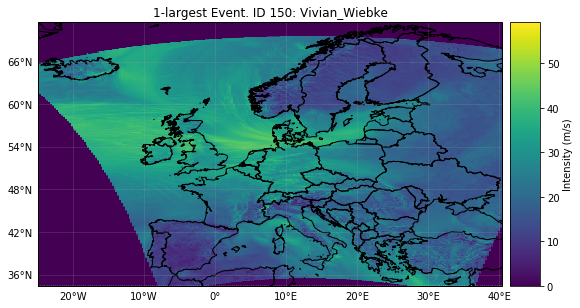

In [4]:
wisc_hist_filename = os.path.join(project_folder, 'WISC_hist' + file_identifier + '.hdf5')
wisc_historic = StormEurope()
if os.path.isfile(wisc_hist_filename):
    wisc_historic.read_hdf5(wisc_hist_filename)
else:
    # create historic hazard


    # create a glob string that selects all era20c and eraint footprints of the netcdf files downloaded above (but not the eraer5 footprints)
    WISC_data_glob = os.path.join(wisc_historic_folder,
                                  'fp_era[!er5]*_0.nc')

    # read all footprints
    wisc_historic.intensity_thres = 0
    wisc_historic.read_footprints(WISC_data_glob,combine_threshold=2)

    # set the Storm Severity Index (SSI) per Storm 
    wisc_historic.set_ssi(threshold=25) #set threshold to 25 m/s

    # set the region id (country identification) of each centroid, allowing the selection of a specific country
    wisc_historic.centroids.set_region_id()

    # save the hazard to a file
    wisc_historic.write_hdf5(wisc_hist_filename)
wisc_historic.plot_intensity(-1)

You now have a CLIMADA hazard containing the information of the "Historic Storm Footprints" provided by WISC. It is save in a file in your project folder (specified above).

### Create the probabilistic event set

There is a documentation about the probabilistic extension in general in the tutorial: TUTORIAL_URL. Additionally the selection of the scale parameter α and the power parameter β from Equation 1 of the paper can be found in "probabilistic_extension.py" in this folder. 

2020-02-28 01:25:56,116 - climada.hazard.base - INFO - Reading C:\Users\ThomasRoosli\Documents\PhD\WISC_phd\paper GVZ\jupyter\WISC_prob_CH_v01.hdf5


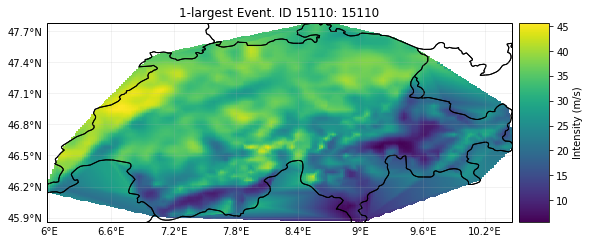

In [5]:
wisc_prob_filename = os.path.join(project_folder, 'WISC_prob_CH' + file_identifier + '.hdf5')
if os.path.isfile(wisc_prob_filename):
    wisc_prob_CH = StormEurope()
    wisc_prob_CH.read_hdf5(wisc_prob_filename)
else:
    # create probabilistic hazard
    ssi_args = {
                'threshold': 25,
                }
    wisc_prob_CH = wisc_historic.generate_prob_storms(reg_id = region_id_CH, ssi_args=ssi_args)
    # write to file
    wisc_prob_CH.write_hdf5(wisc_prob_filename)
wisc_prob_CH.plot_intensity(-1)

You now have created a probabilistically extended hazard event set for Switzerland and saved it to a file.

## Damage Model

### Exposure and Vulnerability

In [6]:
from cartopy.io import shapereader

from climada.entity.exposures import Exposures
import climada.entity.exposures.open_street_map as OSM
from climada.entity.impact_funcs import ImpactFuncSet
from climada.entity.impact_funcs.storm_europe import IFStormEurope


2020-02-28 01:25:58,527 - climada.entity.exposures.base - INFO - Reading C:\Users\ThomasRoosli\Documents\PhD\WISC_phd\paper GVZ\jupyter\litpop_osm_exposure_Zurich_v01.hdf5


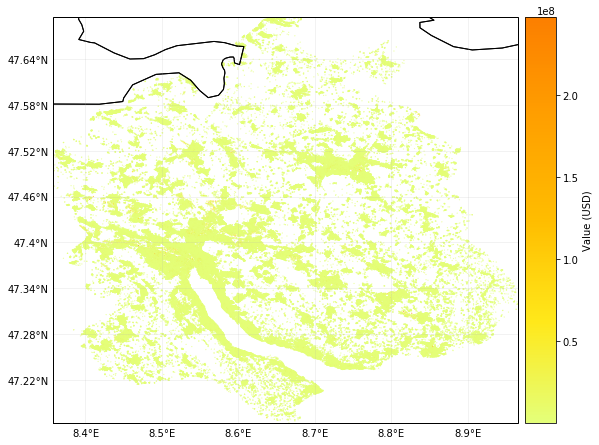

In [7]:
# Exposure
exposure_filename = os.path.join(project_folder, 'litpop_osm_exposure_Zurich' + file_identifier + '.hdf5')
if os.path.isfile(exposure_filename):
    osm_exposure = Exposures()
    osm_exposure.read_hdf5(exposure_filename)
else:
    # get all buildings from Open Street Map
    osm_houses_ZH = OSM.get_features_OSM([47.15944,8.35768,47.694472, 8.984941],
                                         {'building'},
                                         save_path = project_folder,
                                         check_plot=1)
    # Make exposure by distributing LitPop asset values on buildings
    osm_exposure = OSM.make_osmexposure(os.path.join(project_folder,'OSM_features_47_8.shp'),
                                                     country = 'CHE',
                                                     mode="LitPop",
                                                     save_path = project_folder,
                                                     check_plot=1)

    # Select houses within canton of Zurich
    #identify the coordinates in zurich
    admin1_shp_file = shapereader.natural_earth(resolution='10m', \
                    category='cultural', name='admin_1_states_provinces')
    admin1_shp_reader = shapereader.Reader(admin1_shp_file)
    for geom_i, rec_i in zip(admin1_shp_reader.geometries(),admin1_shp_reader.records()):
        if rec_i.attributes['adm0_a3'] == 'CHE':
            if rec_i.attributes['name'] == 'ZÃ¼rich':
                break
    in_geom = u_coordinates.coord_on_land(lat=osm_exposure['latitude'], lon=osm_exposure['longitude'],land_geom=geom_i)
    #set values of houses outside Zurich to zero
    osm_exposure.value[np.invert(in_geom)]=0
    
    # write exposure to file
    osm_exposure.write_hdf5(exposure_filename)
osm_exposure.plot_hexbin(ignore_zero=True)

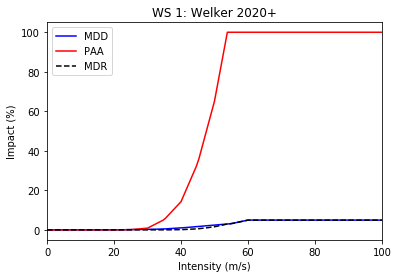

In [8]:
# Vulnerability
impact_function = IFStormEurope()
impact_function.set_welker()
impact_function_set = ImpactFuncSet()
impact_function_set.append(impact_function)
impact_function_set.plot()

### impact calculation

In [9]:
from climada.engine import Impact

In [10]:
# calculate the impact for both hazards
# CLIMADA model and "WISC historic"
osm_exposure.assign_centroids(wisc_historic) 
impact_historic = Impact()
impact_historic.calc(osm_exposure,impact_function_set,wisc_historic)
# CLIMADA model and "WISC probabilistic extension"
osm_exposure.assign_centroids(wisc_prob_CH)
impact_probabilistic = Impact()
impact_probabilistic.calc(osm_exposure,impact_function_set,wisc_prob_CH)

2020-02-28 01:26:16,237 - climada.entity.exposures.base - INFO - Matching 387158 exposures with 1519136 centroids.
2020-02-28 01:26:53,739 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2020-02-28 01:26:53,749 - climada.engine.impact - INFO - Calculating damage for 284293 assets (>0) and 142 events.
2020-02-28 01:26:53,751 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_WS. Using impact functions in if_.
2020-02-28 01:26:58,581 - climada.entity.exposures.base - INFO - Matching 387158 exposures with 3057 centroids.
2020-02-28 01:27:11,734 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2020-02-28 01:27:11,743 - climada.engine.impact - INFO - Calculating damage for 284293 assets (>0) and 4260 events.
2020-02-28 01:27:11,744 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_WS. Using impact functions in if_.


### Figure 1

C:\shortpaths\GitHub\climada_python\climada\util\plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


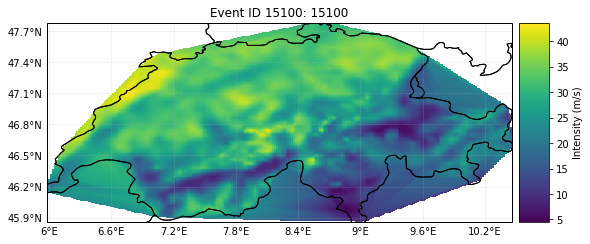

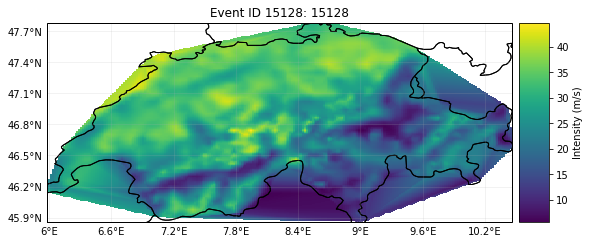

In [31]:
# plot the most damaging event from wisc_historic for the canton of Zurich
historic_max_damage = impact_probabilistic.event_id[impact_probabilistic.at_event==impact_probabilistic.at_event[wisc_prob_CH.orig].max()]
ax = wisc_prob_CH.plot_intensity(event=historic_max_damage)
# plot the most damaging event from wisc_prob_CH for the canton of Zurich
probabilistic_max_damage = impact_probabilistic.event_id[impact_probabilistic.at_event==impact_probabilistic.at_event.max()]
ax = wisc_prob_CH.plot_intensity(event=probabilistic_max_damage)

### Risk Assessment

In [13]:
# define the function that assigns the pareto distribution based on a threshold ("pareto pricing") 
# and produces the resampling
def risk_assessment_pareto(vector_with_damages,final_thres=None,yearly_freq=None):
    thresholds = np.linspace(vector_with_damages.min(),np.percentile(vector_with_damages,75),20)
    shape_per_percentile = np.ones_like(thresholds)
    scale_per_percentile = np.ones_like(thresholds)
    mod_scale_per_percentile = np.ones_like(thresholds)
    mean_excess = np.ones_like(thresholds)
    for ind_i, thres_i in enumerate(thresholds):
        peaks_over_threshold = vector_with_damages[vector_with_damages>thres_i]-thres_i
        shape_i = scipy.stats.genpareto.fit(peaks_over_threshold)
        shape_per_percentile[ind_i] = shape_i[0]
        scale_per_percentile[ind_i] = shape_i[1]
        mod_scale_per_percentile[ind_i] = shape_i[1]-shape_i[0]*thres_i
        mean_excess[ind_i] = np.mean(peaks_over_threshold)

    if final_thres is not None:
        peaks_over_threshold_final = vector_with_damages[vector_with_damages>final_thres]-final_thres
        params_final = scipy.stats.genpareto.fit(peaks_over_threshold_final)
        return_periods = 500/np.power(np.sqrt(2),np.arange(21))
#        frequencies = 1-(1/return_periods) # in [per year]
        quantiles = 1-(1/(return_periods*yearly_freq)) # in quantiles of the distribution
        damages_quantiles_distribution = (scipy.stats.genpareto.ppf(quantiles, 
                                                                   params_final[0],
                                                                   loc=params_final[1],
                                                                   scale=params_final[2])
                                          +final_thres)

        
        return_period_vector = 1/np.cumsum(np.ones_like(vector_with_damages)*(yearly_freq/vector_with_damages.size))
        damage_quantiles_vector = vector_with_damages[np.argsort(-vector_with_damages)]

        #resampling
        number_of_resamplings = 200
        number_of_events = vector_with_damages[vector_with_damages>final_thres].size
        resampling_sample = np.empty([number_of_resamplings,number_of_events])
        resampling_params = np.empty([number_of_resamplings,3])
        resampling_ppf = np.empty([number_of_resamplings,len(return_periods)])
        for ind_i in np.arange(number_of_resamplings):
            #random sample
            sample_i = scipy.stats.genpareto.rvs(params_final[0],
                                                 loc=params_final[1],
                                                 scale=params_final[2],
                                                 size=number_of_events)
            #fit back and save the new parameters and the pdf
            params_i = scipy.stats.genpareto.fit(sample_i)
            resampling_ppf[ind_i,:] = (scipy.stats.genpareto.ppf(quantiles,
                                                                params_i[0],
                                                                loc=params_i[1],
                                                                scale=params_i[2])
                                       +final_thres)
            resampling_sample[ind_i,:] = sample_i
            resampling_params[ind_i,:] = params_i
        
        plt.figure()
        plt.fill_between(return_periods,
                         np.quantile(resampling_ppf,[0.05],axis=0)[0],
                         np.quantile(resampling_ppf,[0.95],axis=0)[0],
                         facecolor = 'b',
                         alpha= 0.3,
                         label='90% confidence interval')
        plt.plot(return_periods,damages_quantiles_distribution,label='Pareto distribution')
        plt.plot(return_period_vector,damage_quantiles_vector,'r.',label='empirical distribution')
#        plt.xlim([1,500])
#        plt.ylim([0,np.nanmax(damages_quantiles_distribution)*2])
        plt.xlim([1,260])
        plt.ylim([0,300])
        plt.xlabel('Return period [years]')
        plt.ylabel('Total damage amount [m CHF]')
        plt.xscale('log')
        plt.legend(['Pareto distribution',
                    'empirical distribution',
                    '90% confidence interval'])

        
        results_dict = {'params_final':params_final,
                        'return_periods':return_periods,
                        'dist_damages':damages_quantiles_distribution,
                        'resampling_damages':resampling_ppf,
                        'return_period_empirical':return_period_vector,
                        'damage_quantiles_empirical':damage_quantiles_vector}
        return results_dict

C:\Users\ThomasRoosli\.conda\envs\climada_env\lib\site-packages\scipy\stats\_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
C:\Users\ThomasRoosli\.conda\envs\climada_env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
C:\Users\ThomasRoosli\.conda\envs\climada_env\lib\site-packages\scipy\stats\_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\ThomasRoosli\.conda\envs\climada_env\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


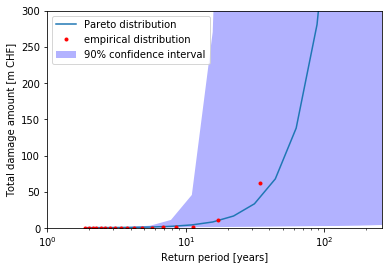

In [14]:
# read the insured damages from file
reported_damages = pd.read_csv(os.path.join(input_folder,
                                       'insured.damage.vs.wisc.historic.csv'))

# assign the pareto distribution ("pareto pricing")
yearly_freq_reported = reported_damages['SchaSum'].size / 34
reported_damages_result = risk_assessment_pareto(reported_damages['SchaSum'],final_thres=0.4,yearly_freq=yearly_freq_reported)


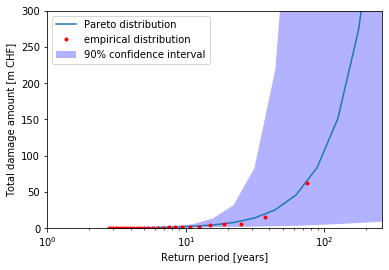

In [15]:
# read the damages modelled with the GVZ damage model and "WISC historic" from file
wisc_historic_gvz_damage = pd.read_csv(os.path.join(input_folder,
                                       'simulated.damage.based.on.wisc.historic.csv'))

# assign the pareto distribution ("pareto pricing")
yearly_freq_wisc_historic = wisc_historic_gvz_damage['SchaSum.MEDIAN'].size / 75
wisc_historic_result = risk_assessment_pareto(wisc_historic_gvz_damage['SchaSum.MEDIAN'],final_thres=0.1,yearly_freq=yearly_freq_wisc_historic)

In [16]:
# read the damages modelled with the GVZ damage model and "WISC probabilistic extension" from file
climada_extension_without_wisc_historic_gvz_damage = pd.read_csv(os.path.join(input_folder,
                                       'simulated.damage.based.on.climada.extension.EXCL.WISC.HISTORIC.csv'))
climada_extension_gvz_damage = copy.deepcopy(wisc_historic_gvz_damage).append( \
                                            copy.deepcopy(climada_extension_without_wisc_historic_gvz_damage))

# format the modelled damages the same way as others
yearly_freq_climada_extension = climada_extension_gvz_damage['SchaSum.MEDIAN'].size / 2250
return_period_climada_extension = 1/np.cumsum(np.ones_like(climada_extension_gvz_damage['SchaSum.MEDIAN'])*(yearly_freq_climada_extension/climada_extension_gvz_damage['SchaSum.MEDIAN'].size))
damage_quantiles_climada_extension = climada_extension_gvz_damage['SchaSum.MEDIAN'].values[np.argsort(-climada_extension_gvz_damage['SchaSum.MEDIAN'].values)]


In [17]:
# format CLIMADA modelling results the same way as others
yearly_freq_climada_extension_climada = impact_probabilistic.at_event.size/2250
return_period_climada_extension_climada = 1/np.cumsum(np.ones_like(impact_probabilistic.at_event)*(yearly_freq_climada_extension_climada/impact_probabilistic.at_event.size))
damage_quantiles_climada_extension_climada = impact_probabilistic.at_event[np.argsort(-impact_probabilistic.at_event)]/1000000


In [18]:
damage_quantiles_climada_extension_climada.max()

165.34231949493608

### Figure 2

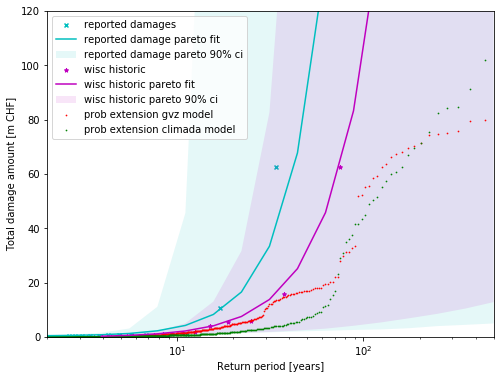

In [19]:
# plot all three risk assessments
plt.figure(figsize=(8,6))
plt.fill_between(reported_damages_result['return_periods'],
                 np.quantile(reported_damages_result['resampling_damages'],[0.05],axis=0)[0],
                 np.quantile(reported_damages_result['resampling_damages'],[0.95],axis=0)[0],
                 facecolor = 'c',
                 alpha= 0.1,
                 label='reported damage pareto 90% ci')
plt.plot(reported_damages_result['return_periods'],reported_damages_result['dist_damages'],'c-', label='reported damage pareto fit')
plt.scatter(reported_damages_result['return_period_empirical'],reported_damages_result['damage_quantiles_empirical'],c='c',marker='x',s=16, label='reported damages')
plt.fill_between(wisc_historic_result['return_periods'],
                 np.quantile(wisc_historic_result['resampling_damages'],[0.05],axis=0)[0],
                 np.quantile(wisc_historic_result['resampling_damages'],[0.95],axis=0)[0],
                 facecolor = 'm',
                 alpha= 0.1,
                 label='wisc historic pareto 90% ci')
plt.plot(wisc_historic_result['return_periods'],wisc_historic_result['dist_damages'],'m-', label='wisc historic pareto fit')
plt.scatter(wisc_historic_result['return_period_empirical'],wisc_historic_result['damage_quantiles_empirical'],c='m',marker='*',s=16, label='wisc historic')
plt.scatter(return_period_climada_extension,damage_quantiles_climada_extension,c='r',marker='.',s=2, label='prob extension gvz model')
plt.scatter(return_period_climada_extension_climada,damage_quantiles_climada_extension_climada,c='g',marker='.',s=2, label='prob extension climada model')
plt.xlim([2,500])
plt.ylim([0,120])
#plt.xlim([2,1000])
#plt.ylim([0,200])
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('Return period [years]')
plt.ylabel('Total damage amount [m CHF]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,2,5,1,4,6,7]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

### Figure 3

Text(0, 0.5, 'insured damage / CHF m.')

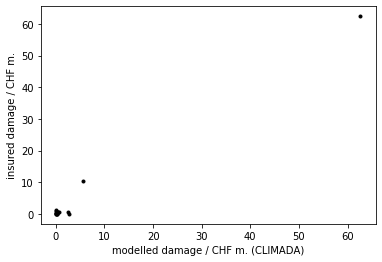

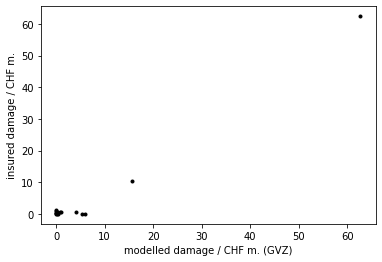

In [55]:
plt.figure()
climada_model_damages = [impact_probabilistic.at_event[impact_probabilistic.event_id==x]/1000000 for x in reported_damages['Ereignis.ID']]
plt.plot(climada_model_damages,reported_damages['SchaSum'],'.k')
plt.xlabel('modelled damage / CHF m. (CLIMADA)')
plt.ylabel('insured damage / CHF m.')
plt.figure()
gvz_model_damages = [climada_extension_gvz_damage['SchaSum.MEDIAN'][climada_extension_gvz_damage['Ereignis.ID']==x].values[0] for x in reported_damages['Ereignis.ID']]
plt.plot(gvz_model_damages, reported_damages['SchaSum'],'.k')
plt.xlabel('modelled damage / CHF m. (GVZ)')
plt.ylabel('insured damage / CHF m.')

### Figure 4

(90, 145)

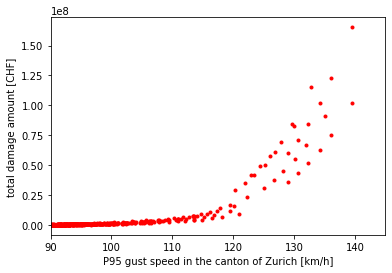

In [32]:
def get_ZH_percentile(haz,percentile=95):
    """ get the 95th percentile of the wind intensity for each storm """
    #identify the centroids in zurich
    admin1_shp_file = shapereader.natural_earth(resolution='10m', \
                    category='cultural', name='admin_1_states_provinces')
    admin1_shp_reader = shapereader.Reader(admin1_shp_file)
    for geom_i, rec_i in zip(admin1_shp_reader.geometries(),admin1_shp_reader.records()):
        if rec_i.attributes['adm0_a3'] == 'CHE':
            if rec_i.attributes['name'] == 'ZÃ¼rich':
                break
    in_geom = u_coordinates.coord_on_land(lat=haz.centroids.lat, lon=haz.centroids.lon,land_geom=geom_i)
    # calculate the percentile
    ZH_percentiles = np.ones_like(haz.frequency)
    for index in range(ZH_percentiles.size):
        ZH_percentiles[index] = np.percentile(haz.intensity[index,in_geom].todense(),percentile)
        
    return ZH_percentiles

# calculate the 95 percentile of winddamages weighted with building values
ZH_percentiles_prob = get_ZH_percentile(wisc_prob_CH)

# plot the damages
plt.figure()
plt.plot(ZH_percentiles_prob*3.6, impact_probabilistic.at_event,'r.')
plt.ylabel('total damage amount [CHF]')
plt.xlabel('P95 gust speed in the canton of Zurich [km/h]')
plt.xlim([90, 145])

### Table 1


In [121]:
def return_period_damage(damages_vec, return_periods_vec, return_period, string=''):
    ind_low = np.where(return_periods_vec < return_period)[0][0]
    ind_up = ind_low-1
    damage = ((damages_vec[ind_low]*
               (return_periods_vec[ind_up]-return_period)/
               (return_periods_vec[ind_up]-return_periods_vec[ind_low]))
              +
              (damages_vec[ind_up]*
               (return_period-return_periods_vec[ind_low])/
               (return_periods_vec[ind_up]-return_periods_vec[ind_low])))
    print(string + 'Event damage with ' + str(return_period) + '-year RP: CHF '+ str(damage) +' million')
    return damage


In [122]:
# insured damages

In [123]:
print('AAD insured damages: CHF ' + str(reported_damages['SchaSum'].sum()/34) +' million')


AAD insured damages: CHF 2.3386304308823527 million


In [125]:
insured_damages_str = 'insured damages: '
return_period_damage(reported_damages_result['damage_quantiles_empirical'].values,
                     reported_damages_result['return_period_empirical'],
                     5,
                    insured_damages_str)

insured damges: Event damage with 5-year RP: CHF 0.6074264623529412 million


0.6074264623529412

In [86]:
return_period_damage(reported_damages_result['damage_quantiles_empirical'].values,
                     reported_damages_result['return_period_empirical'],
                     10,
                    insured_damages_str)

1.0841843670588234

In [87]:
reported_damages_result['damage_quantiles_empirical'].max()

62.42682106

In [ ]:
# wisc historic and GVZ model

In [93]:
print('AAD wisc historic: CHF ' + str(wisc_historic_result['damage_quantiles_empirical'].sum()/75) +' million')


AAD insured damages: CHF 1.3683385586666665 million


In [138]:
wisc_historic_str = 'wisc historic: '
return_period_damage(wisc_historic_result['damage_quantiles_empirical'].values,
                     wisc_historic_result['return_period_empirical'],
                     5,
                    wisc_historic_str)

wisc historic: Event damage with 5-year RP: CHF 0.2099144 million


0.2099144

In [139]:
return_period_damage(wisc_historic_result['damage_quantiles_empirical'].values,
                     wisc_historic_result['return_period_empirical'],
                     10,
                    wisc_historic_str)

wisc historic: Event damage with 10-year RP: CHF 1.2631567733333335 million


1.2631567733333335

In [140]:
return_period_damage(wisc_historic_result['damage_quantiles_empirical'].values,
                     wisc_historic_result['return_period_empirical'],
                     50,
                    wisc_historic_str)

wisc historic: Event damage with 50-year RP: CHF 31.3559311 million


31.3559311

In [141]:
wisc_historic_result['damage_quantiles_empirical'].max()

62.7226257

In [ ]:
# probabilistic extension and GVZ model

In [94]:
print('AAD probabilistic extension: CHF ' + str(damage_quantiles_climada_extension.sum()/2250) +' million')


AAD insured damages: CHF 1.4454457581777778 million


In [130]:
wisc_prob_str = 'wisc probabilistic extension: '
return_period_damage(damage_quantiles_climada_extension,
                     return_period_climada_extension,
                     5,
                    wisc_prob_str)

wisc probabilistic extension: Event damage with 5-year RP: CHF 0.23571509999999715 million


0.23571509999999715

In [128]:
return_period_damage(damage_quantiles_climada_extension,
                     return_period_climada_extension,
                     10,
                    wisc_prob_str)

wisc probabilistic extension: Event damage with 10-year RP: CHF 1.3350463999999922 million


1.3350463999999922

In [129]:
return_period_damage(damage_quantiles_climada_extension,
                     return_period_climada_extension,
                     50,
                    wisc_prob_str)

wisc probabilistic extension: Event damage with 50-year RP: CHF 16.978986000000003 million


16.978986000000003

In [131]:
return_period_damage(damage_quantiles_climada_extension,
                     return_period_climada_extension,
                     250,
                     wisc_prob_str)

wisc probabilistic extension: Event damage with 250-year RP: CHF 74.6332142 million


74.6332142

### Table A1

In [ ]:
# wisc historic and CLIMADA model

In [105]:
print('AAD wisc historic: CHF ' + str(impact_historic.at_event.sum()/75/1000000) +' million')


AAD wisc historic: CHF 1.0633878309647198 million


In [142]:
return_period_damage(impact_historic.at_event[np.argsort(-impact_historic.at_event)]/1000000,
                     wisc_historic_result['return_period_empirical'],
                     5,
                    wisc_historic_str)

wisc historic: Event damage with 5-year RP: CHF 0.18843706752671074 million


0.18843706752671074

In [143]:
return_period_damage(impact_historic.at_event[np.argsort(-impact_historic.at_event)]/1000000,
                     wisc_historic_result['return_period_empirical'],
                     10,
                    wisc_historic_str)

wisc historic: Event damage with 10-year RP: CHF 0.6137121983425802 million


0.6137121983425802

In [144]:
return_period_damage(impact_historic.at_event[np.argsort(-impact_historic.at_event)]/1000000,
                     wisc_historic_result['return_period_empirical'],
                     50,
                    wisc_historic_str)

wisc historic: Event damage with 50-year RP: CHF 24.54395112052727 million


24.54395112052727

In [145]:
impact_historic.at_event.max()/1000000 # event damage Lothar/Martin

62.636920090393225

In [ ]:
# probabilistic extension and CLIMADA model

In [103]:
print('AAD probabilistic extension: CHF ' + str(damage_quantiles_climada_extension_climada.sum()/2250) +' million')


AAD probabilistic extension: CHF 1.1854333887268227 million


In [132]:
return_period_damage(damage_quantiles_climada_extension_climada,
                     return_period_climada_extension_climada,
                     5,
                    wisc_prob_str)

wisc probabilistic extension: Event damage with 5-year RP: CHF 0.21336100200416533 million


0.21336100200416533

In [133]:
return_period_damage(damage_quantiles_climada_extension_climada,
                     return_period_climada_extension_climada,
                     10,
                    wisc_prob_str)

wisc probabilistic extension: Event damage with 10-year RP: CHF 0.6146892073596611 million


0.6146892073596611

In [134]:
return_period_damage(damage_quantiles_climada_extension_climada,
                     return_period_climada_extension_climada,
                     50,
                    wisc_prob_str)

wisc probabilistic extension: Event damage with 50-year RP: CHF 7.387379150066539 million


7.387379150066539

In [135]:
return_period_damage(damage_quantiles_climada_extension_climada,
                     return_period_climada_extension_climada,
                     250,
                    wisc_prob_str)

wisc probabilistic extension: Event damage with 250-year RP: CHF 82.47314865886618 million


82.47314865886618